# Plot output h5 data generated via ddcurves



In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
#from mpl_toolkits.axisartist.
from matplotlib.collections import LineCollection

import seaborn as sns

#%matplotlib inline

/home/suntans/.conda/envs/soda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The backend.qt5 rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1. In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/home/suntans/.conda/envs/soda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed

In [2]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize':'small'})

In [3]:
#f = h5py.File('DATA_QC/test_beta-samples.h5','r')
#h5file = 'DATA_QC/IMOS_Density_KIM200_2013_a_beta-samples-array-all-data.h5'

#datadir = '../../run_ddcurves/'
datadir = '/home/suntans/cloudstor/Data/Crux/'
datafile1 = '%s/Crux_KP150_Phs1_Density_lowpass'%datadir
datafile2 = '%s/Crux_KP150_Phs2_Density_lowpass'%datadir
sitename = 'CRUX'
zmin = -250

#datafile1 = 'DATA_QC/IMOS_Density_PIL200_2013_b'
#datafile2 = 'DATA_QC/IMOS_Density_PIL200_2014_a'
#sitename = 'PIL200'
#zmin = -205

#datafile1 = 'DATA_QC/IMOS_Density_KIM200_2013_b'
#datafile2 = 'DATA_QC/IMOS_Density_KIM200_2014_a'
#sitename = 'KIM200'
#zmin = -205


# Load

Data is stored in hdf5 format. The $\beta$'s are stored in the group `data/beta_samples` that has dimensions [#parameters, #time, #samples]

In [4]:
def load_density_h5(h5file):
    f = h5py.File(h5file,'r')
    data = f['data/beta_samples'][:]
    f.close()
    return data


data1 = load_density_h5('%s_beta-samples-array-all-data.h5'%datafile1)
data2 = load_density_h5('%s_beta-samples-array-all-data.h5'%datafile2)

data = np.concatenate([data1,data2], axis=1)
nparam, nt, ntrace = data[:].shape
print(nparam, nt, ntrace)

6 1481 1500


In [5]:
def convert_time(tt):
    try:
        dt= datetime.strptime(tt, '%Y-%m-%dT%H:%M:%S')
    except:
        dt= datetime.strptime(tt, '%Y-%m-%d %H:%M')
    return dt

def read_density_csv(csvfile):
    # Reads into a dataframe object
    df = pd.read_csv(csvfile, index_col=0, sep=', ', parse_dates=['Time'], date_parser=convert_time)

    # Load the csv data
    depths= np.array([float(ii) for ii in df.columns.values])
    rho_obs_tmp = df[:].values.astype(float)
    time = df.index[:]

    # Clip the top
    rho_obs_2d = rho_obs_tmp[:,:]

    # Remove some nan
    fill_value = 1024.
    rho_obs_2d[np.isnan(rho_obs_2d)] = fill_value
    
    return xr.DataArray(rho_obs_2d,dims=('time', 'depth'),
            coords={'time':time.values,'depth':depths})

rho1 = read_density_csv('%s.csv'%datafile1)
rho2 = read_density_csv('%s.csv'%datafile2)

rho = xr.concat([rho1,rho2], dim='time')


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


In [6]:
def double_tanh(beta, z):
    
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
                + np.tanh((z+beta[4])/beta[5]))

In [7]:
dz = 2.5
mode = 0
zout = np.arange(zmin, dz, dz)

rho.time[[27,469,647]]

<xarray.DataArray 'time' (time: 3)>
array(['2016-05-06T17:15:00.000000000', '2016-08-25T05:15:00.000000000',
       '2016-10-08T17:15:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-05-06T17:15:00 ... 2016-10-08T17:15:00

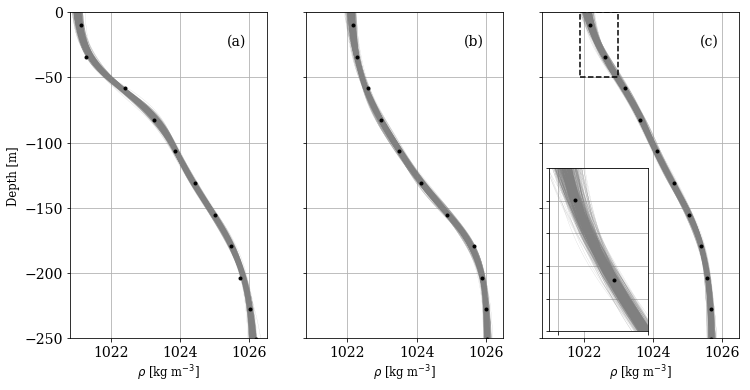

In [8]:
plt.figure(figsize=(12,6))
def plot_rho_step(tstep,ax ):
    samples = 500
    #for rand_loc in np.random.randint(0, ntrace, samples):
    #    rhotmp = double_tanh(data[:,tstep, rand_loc], zout)
    #    plt.plot(rhotmp, zout, '0.5', lw=0.2, alpha=0.5)
    lc = LineCollection([np.column_stack([double_tanh(data[:,tstep, rand_loc],zout), zout]) \
                        for rand_loc in np.random.randint(0,ntrace,samples)],\
                       lw=0.2, alpha=0.5, color='0.5',rasterized=True)
    
    ax.add_collection(lc)

    ax.plot(rho[tstep,:],rho.depth[:], 'k.')
    #plt.plot(rhomean*RHO0, zout, 'k--',) # Mean fit
    plt.ylim(zmin,0 )
    plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
    plt.grid(b=True)
    plt.xlim(1020.8,1026.5)




ax1 = plt.subplot(131, )
plot_rho_step(27,ax1)

ax2 = plt.subplot(132, )
plot_rho_step(469,ax2)

ax3 = plt.subplot(133,)
plot_rho_step(647,ax3)
plt.plot([1021.9,1023,1023,1021.9,1021.9],[-50,-50,0,0,-50],'k--')


# Add an inset axes to panel (c)
ax4 = inset_ax = inset_axes(ax3,
                          height="50%", # set height
                          width="50%", # and width
                          loc='lower left') #
plot_rho_step(647,ax4)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.set_ylim(-50,0)
ax4.set_xlim(1021.9,1023)
ax4.set_xlabel('')


ax1.set_ylabel('Depth [m]')
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax1.text(0.8,0.9,'(a)',transform=ax1.transAxes)
ax2.text(0.8,0.9,'(b)',transform=ax2.transAxes)
ax3.text(0.8,0.9,'(c)',transform=ax3.transAxes)

#plt.title(rho.time.values[tstep])
plt.savefig("../FIGURES/density_fulldistribution_3examples.png", dpi=150)
plt.savefig("../FIGURES/density_fulldistribution_3examples.pdf", dpi=300)

plt.show()

In [9]:
# Print the mean beta's
print(data[:,27,:].mean(axis=-1).tolist())
print(data[:,469,:].mean(axis=-1).tolist())
print(data[:,647,:].mean(axis=-1).tolist())

[1023.565795828482, 1.301493332110207, 59.77512370070264, 30.718892541433142, 151.1718555879332, 55.07143851321288]
[1024.051701579007, 1.007728285355818, 89.04760042402614, 52.95615549755212, 154.66072602557503, 37.66507633101198]
[1023.79433645181, 0.9650978830345366, 46.382691209500585, 44.405881470725774, 138.8485310171459, 50.52846467379077]


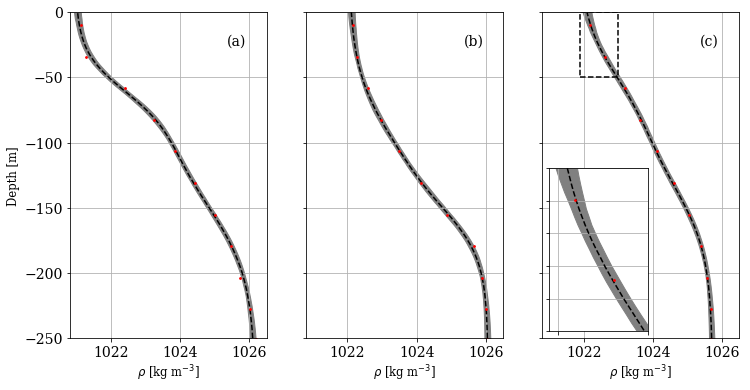

In [10]:
# Plot the credible intervals for each step
def plot_credint(tstep):
    samples = 500
    nz = zout.shape[0]
    rho_tstep = np.zeros((nz,samples))

    for ii,rand_loc in enumerate(np.random.randint(0, ntrace, samples)):
        rho_tstep[:,ii] = double_tanh(data[:,tstep, rand_loc], zout)

    rho5 = np.percentile(rho_tstep, 5, axis=1)
    rho50 = np.percentile(rho_tstep, 50, axis=1)
    rho95 = np.percentile(rho_tstep, 95, axis=1)

    #plt.plot(rho95-rho5,zout,'0.5')
    #plt.xlim(0,0.25)
    
    plt.fill_betweenx(zout, rho5, rho95, color='0.5')
    plt.plot(rho50, zout,'--', color='k')
    
    plt.plot(rho[tstep,:],rho.depth[:], 'r.',ms=3.5)

    plt.grid(b=True)
    plt.xlim(1020.8,1026.5)
    plt.ylim(zmin,0 )
    plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
    
    



plt.figure(figsize=(12,6))    
ax1 = plt.subplot(131)
plot_credint(27)

ax2 = plt.subplot(132)
plot_credint(469)

ax3 = plt.subplot(133)
plot_credint(647)

plt.plot([1021.9,1023,1023,1021.9,1021.9],[-50,-50,0,0,-50],'k--')

ax1.set_ylabel('Depth [m]')

ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax1.text(0.8,0.9,'(a)',transform=ax1.transAxes)
ax2.text(0.8,0.9,'(b)',transform=ax2.transAxes)
ax3.text(0.8,0.9,'(c)',transform=ax3.transAxes)

# Add an inset axes to panel (c)
ax4 = inset_ax = inset_axes(ax3,
                          height="50%", # set height
                          width="50%", # and width
                          loc='lower left') #
plot_credint(647)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.set_ylim(-50,0)
ax4.set_xlim(1021.9,1023)
ax4.set_xlabel('')

plt.savefig("../FIGURES/density_posterior_3examples.png", dpi=150)
plt.savefig("../FIGURES/density_posterior_3examples.pdf", dpi=300)

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


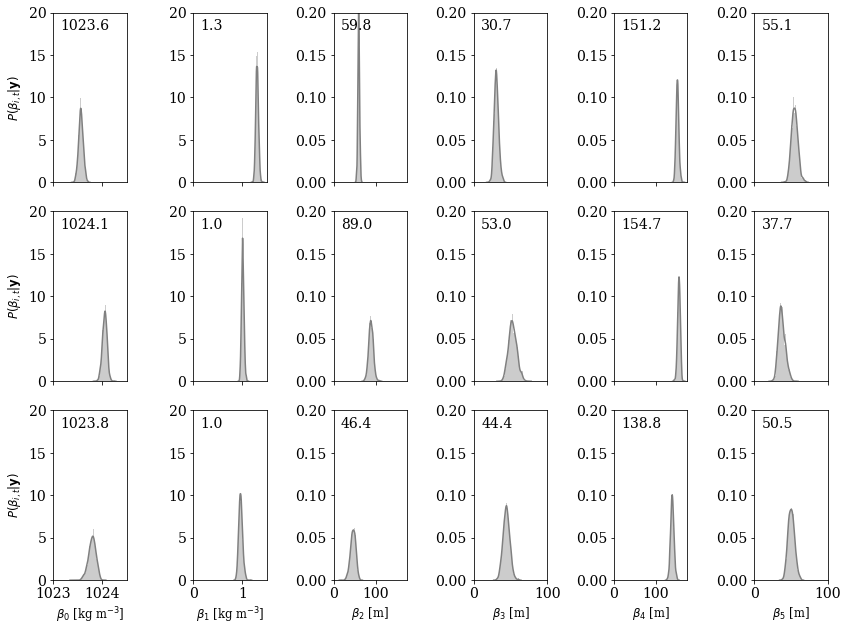

In [11]:
# Plot the distribution of beta's
tstep = 647
#plt.hist(data[0,tstep, :], bins=50, normed=True)
beta_units = ['kg m$^{-3}$', 'kg m$^{-3}$', 'm', 'm', 'm', 'm']
xlims = [(1023,1024.5), (0,1.5), (0,175), (0,100), (0,175), (0,100)]
plt.figure(figsize=(12,9))

def plot_beta_dist(tstep, nrows, row, xticks=True):
    for ii in range(6):
        ax = plt.subplot(nrows,6,row*6+ii+1)

        sns.distplot(data[ii,tstep, :],\
                    color='0.5', norm_hist=True)
            #bins=np.linspace(xlims[ii][0],xlims[ii][0],50), norm_hist=True, )
        
        if xticks:
            plt.xlabel(r'$\beta_{}$ [{}]'.format(ii,beta_units[ii]))
        else:
            ax.set_xticklabels([])
            
        #ax.set_yticklabels([])
        #plt.grid(b=True)
        ax.set_xlim(xlims[ii])
        if ii > 1:
            ax.set_ylim(0,0.2)
        else:
            ax.set_ylim(0,20)

        # Print out the mean
        plt.text(0.1,0.9, '%3.1f'%(np.mean(data[ii,tstep, :])), transform=ax.transAxes)
        
        if ii == 0:
            #plt.ylabel(str(rho.time.values[tstep])[0:10])
            plt.ylabel(r'$P(\beta_{i,t}|\mathbf{y})$')


plot_beta_dist(27, 3, 0, xticks=False)
plot_beta_dist(469, 3, 1, xticks=False)
plot_beta_dist(647, 3, 2)

plt.tight_layout()

plt.savefig("../FIGURES/beta_posterior_3examples.png", dpi=150)
plt.savefig("../FIGURES/beta_posterior_3examples.pdf", dpi=300)

In [24]:
str(rho.time.values[tstep])[0:10]

'2016-10-08'

In [25]:
from iwaves import kdv
from iwaves.utils import isw

In [26]:
def calc_N2_phi(data, tstep):
    nz = zout.shape[0]
    N2_tstep = np.zeros((nz,samples))
    phi1_tstep = np.zeros((nz,samples))
    phi2_tstep = np.zeros((nz,samples))


    rand_loc = np.random.randint(0, ntrace, samples)
    for ii in range(samples):
        rhotmp = double_tanh(data[:,tstep, rand_loc[ii]], zout)

        N2 = -9.81/1000*np.gradient(rhotmp,dz)

        phi,cn = isw.iwave_modes(N2, dz)
        
        phi_1 = phi[:,0]
        phi_1 =phi_1 / np.abs(phi_1).max()
        phi_1 *= np.sign(phi_1.sum())
        
        phi_2 = phi[:,1]
        phi_2 =phi_2 / np.abs(phi_2).max()
        phi_2 *= np.sign(phi_2.sum())
        
        N2_tstep[:,ii] = N2
        phi1_tstep[:,ii] = phi_1
        phi2_tstep[:,ii] = phi_2

        
    return N2_tstep, phi1_tstep, phi2_tstep

[[-127.5]
 [-125. ]
 [-122.5]
 [-120. ]
 [-117.5]
 [-115. ]
 [-112.5]
 [-110. ]
 [-107.5]
 [-105. ]
 [-102.5]
 [-100. ]
 [ -97.5]]
[[-142.5]
 [-140. ]
 [-137.5]
 [-135. ]
 [-132.5]
 [-130. ]
 [-127.5]
 [-125. ]
 [-122.5]
 [-120. ]
 [-117.5]]
[[-132.5]
 [-130. ]
 [-127.5]
 [-125. ]
 [-122.5]
 [-120. ]
 [-117.5]
 [-115. ]
 [-112.5]
 [-110. ]
 [-107.5]
 [-105. ]]


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


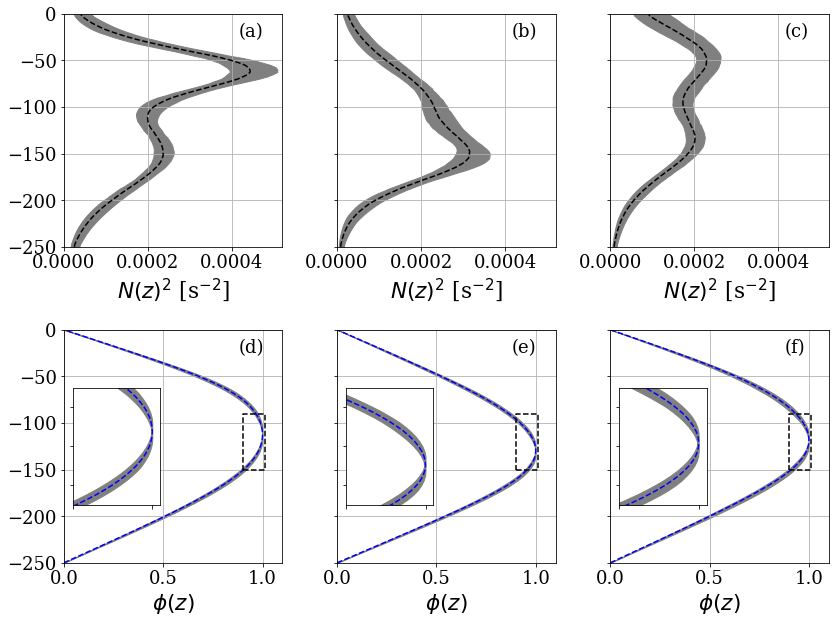

In [118]:
def plot_N2(data, tstep, ax1, ax2):
    N2, phi, phi2 = calc_N2_phi(data,tstep)
    
    N2_5 = np.percentile(N2, 5, axis=1)
    N2_50 = np.percentile(N2, 50, axis=1)
    N_95 = np.percentile(N2, 95, axis=1)
    
    phi_5 = np.percentile(phi, 5, axis=1)
    phi_50 = np.percentile(phi, 50, axis=1)
    phi_95 = np.percentile(phi, 95, axis=1)

    phi2_5 = np.percentile(phi2, 5, axis=1)
    phi2_50 = np.percentile(phi2, 50, axis=1)
    phi2_95 = np.percentile(phi2, 95, axis=1)
    
    ax1.fill_betweenx(zout, N2_5, N_95, color='0.5')
    ax1.plot(N2_50, zout,'k--')
    ax1.set_ylim(-250,0)
    ax1.set_xlim(0,5.2e-4)
    ax1.grid(b=True)
    
    ax2.fill_betweenx(zout, phi_5, phi_95, color='0.5')
    ax2.plot(phi_50, zout,'--', color='b')
    ax2.set_ylim(-250,0)
    ax2.set_xlim(0,1.1)
    
    ax2.plot([0.9,1.01,1.01,0.9,0.9], [-150,-150,-90,-90,-150],'k--')
    ax2.grid(b=True)

    
    ax3 = inset_ax = inset_axes(ax2,
                          height="50%", # set height
                          width="40%", # and width
                          loc='center left') #
    
    ax3.fill_betweenx(zout, phi_5, phi_95, color='0.5')
    ax3.plot(phi_50, zout,'--', color='b')
    
    ax3.set_ylim(-150,-90)
    ax3.set_xlim(0.9,1.01)
    
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    
    #ax2.fill_betweenx(zout, phi2_5, phi2_95, color='0.5')
    #ax2.plot(phi2_50, zout,'--', color='r')
    
    idx = np.argwhere(phi_95>=0.99)
    print(zout[idx])
    return phi_95

    
plt.figure(figsize=(12,9))    
ax1 = plt.subplot(231)
ax4 = plt.subplot(234)

plot_N2(data,27, ax1,ax4)

ax2 = plt.subplot(232)
ax5 = plt.subplot(235)

plot_N2(data,469, ax2,ax5)

ax3 = plt.subplot(233)
ax6 = plt.subplot(236)

plot_N2(data,647,ax3,ax6)

ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

ax1.text(0.8,0.9,'(a)',transform=ax1.transAxes)
ax2.text(0.8,0.9,'(b)',transform=ax2.transAxes)
ax3.text(0.8,0.9,'(c)',transform=ax3.transAxes)
ax1.set_xlabel('$N(z)^2$ [s$^{-2}$]')
ax2.set_xlabel('$N(z)^2$ [s$^{-2}$]')
ax3.set_xlabel('$N(z)^2$ [s$^{-2}$]')


ax4.text(0.8,0.9,'(d)',transform=ax4.transAxes)
ax5.text(0.8,0.9,'(e)',transform=ax5.transAxes)
ax6.text(0.8,0.9,'(f)',transform=ax6.transAxes)
ax4.set_xlabel('$\phi(z)$')
ax5.set_xlabel('$\phi(z)$')
ax6.set_xlabel('$\phi(z)$')

plt.tight_layout()

plt.savefig("../FIGURES/N2phi_posterior_3examples.png", dpi=150)
plt.savefig("../FIGURES/N2phi_posterior_3examples.pdf")

In [9]:
#%%time
from tqdm import tqdm # progress bar

samples = 200
alpha_ens = np.zeros((nt,samples))
c_ens = np.zeros((nt,samples))

rand_loc = np.random.randint(0, ntrace, samples)

for tstep in tqdm(range(0,nt)):
    #if (tstep%20==0):
    #    print('%d of %d...'%(tstep,nt))
    for ii in range(samples):
        rhotmp = double_tanh(data[:,tstep, rand_loc[ii]], zout)

        N2 = -9.81/1000*np.gradient(rhotmp,dz)

        phi,cn = isw.iwave_modes(N2, dz)
        
        phi_1 = phi[:,mode]
        phi_1 =phi_1 / np.abs(phi_1).max()
        phi_1 *= np.sign(phi_1.sum())
        
        alpha = isw.calc_alpha(phi_1, cn[mode],N2,dz)

        alpha_ens[tstep,ii] = alpha
        c_ens[tstep,ii] = cn[mode]
        #mykdv = kdv.KdV(rhotmp,zout)


100%|██████████| 1481/1481 [13:46<00:00,  1.79it/s]

CPU times: user 47min 27s, sys: 3min 23s, total: 50min 50s
Wall time: 13min 46s


In [10]:
omega = 2*np.pi/(12.42*3600)
a0 = 25.

Ls = c_ens**2. / (np.abs(alpha_ens)*a0*omega) / 1000.
Ls_median = np.median(c_ens,axis=1)**2. / (np.abs(np.median(alpha_ens,axis=1))*a0*omega) / 1000.

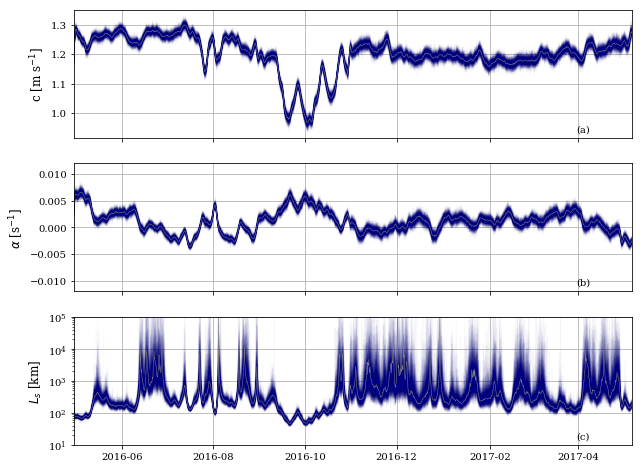

In [11]:
#time = range(0,nt)
time = rho.time.values

plt.figure(figsize=(10,8))
ax1 = plt.subplot(311, rasterized=False)
ax2 = plt.subplot(312, rasterized=False)
ax3 = plt.subplot(313, yscale='log', rasterized=False)

#ax1.set_ylim(0.75,1.35)
ax2.set_ylim(-0.012,0.012)
ax3.set_ylim(1e1,1e5)
ax1.set_ylabel('c [m s$^{-1}$]')
ax2.set_ylabel(r'$\alpha$ [s$^{-1}$]')
ax3.set_ylabel(r'$L_s$ [km]')

ax1.grid(b=True)
ax2.grid(b=True)
ax3.grid(b=True)

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax1.set_xlim([time[0],time[-1]])
ax2.set_xlim([time[0],time[-1]])
ax3.set_xlim([time[0],time[-1]])

ax1.text(0.9,0.05,'(a)', transform=ax1.transAxes)
ax2.text(0.9,0.05,'(b)', transform=ax2.transAxes)
ax3.text(0.9,0.05,'(c)', transform=ax3.transAxes)

c_lines = np.zeros((samples,nt,2))
for ii in range(samples):
    #c_lines[ii,:,0]  = range(nt)
    #c_lines[ii,:,1]  = c_ens[:,ii]
    p1, = ax1.plot(time,c_ens[:,ii],'navy', lw=1, alpha=0.02)
    p1.set_rasterized(True)
    
    p1, = ax2.plot(time,alpha_ens[:,ii],'navy', lw=1, alpha=0.02)
    p1.set_rasterized(True)

    p1, = ax3.plot(time,Ls[:,ii],'navy', lw=1, alpha=0.02)
    p1.set_rasterized(True)

#l1 = LineCollection(c_lines)
#ax1.add_collection(l1)
ax1.plot(time, np.median(c_ens,axis=1),'0.5',lw=0.5)
ax2.plot(time, np.median(alpha_ens,axis=1),'0.5',lw=0.5)
ax3.plot(time, Ls_median,'0.5',lw=0.5)

plt.savefig('FIGURES/c_alpha_Ls_uncert_%s.pdf'%sitename, dpi=150)
plt.savefig('FIGURES/c_alpha_Ls_uncert_%s.png'%sitename, dpi=150)

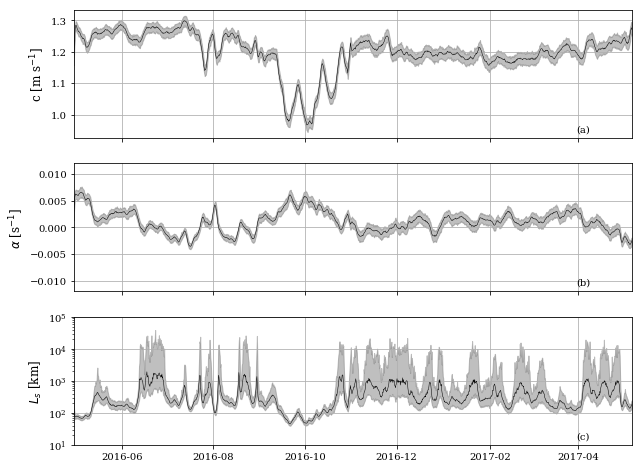

In [12]:
#time = range(0,nt)
time = rho.time.values

plt.figure(figsize=(10,8))
ax1 = plt.subplot(311, rasterized=False)
ax2 = plt.subplot(312, rasterized=False)
ax3 = plt.subplot(313, yscale='log', rasterized=False)

#ax1.set_ylim(0.75,1.35)
ax2.set_ylim(-0.012,0.012)
ax3.set_ylim(1e1,1e5)
ax1.set_ylabel('c [m s$^{-1}$]')
ax2.set_ylabel(r'$\alpha$ [s$^{-1}$]')
ax3.set_ylabel(r'$L_s$ [km]')

ax1.grid(b=True)
ax2.grid(b=True)
ax3.grid(b=True)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_yticks([10,1e2,1e3,1e4,1e5])

ax1.set_xlim([time[0],time[-1]])
ax2.set_xlim([time[0],time[-1]])
ax3.set_xlim([time[0],time[-1]])

ax1.text(0.9,0.05,'(a)', transform=ax1.transAxes)
ax2.text(0.9,0.05,'(b)', transform=ax2.transAxes)
ax3.text(0.9,0.05,'(c)', transform=ax3.transAxes)

ax1.plot(time, np.median(c_ens,axis=1),'k',lw=0.5)
ax2.plot(time, np.median(alpha_ens,axis=1),'k',lw=0.5)
ax3.plot(time, np.percentile(Ls,50, axis=1,),'k',lw=0.5)
#ax3.plot(time, Ls_median,'k',lw=0.5)

ax1.fill_between(time,np.percentile(c_ens,5, axis=1),np.percentile(c_ens,95, axis=1),\
        color='0.5', alpha=0.5)

ax2.fill_between(time,np.percentile(alpha_ens,5, axis=1),np.percentile(alpha_ens,95, axis=1),\
        color='0.5', alpha=0.5)

ax3.fill_between(time,np.percentile(Ls,5, axis=1),np.percentile(Ls,95, axis=1),\
        color='0.5', alpha=0.5)


plt.savefig('FIGURES/c_alpha_Ls_uncert_95c_%s.pdf'%sitename, dpi=150)
plt.savefig('FIGURES/c_alpha_Ls_uncert_95c_%s.png'%sitename, dpi=150)

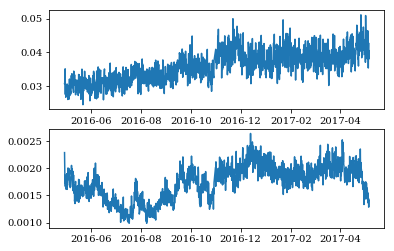

In [13]:
c_diff = np.percentile(c_ens,95, axis=1) - np.percentile(c_ens,5, axis=1)
alpha_diff = np.percentile(alpha_ens,95, axis=1) - np.percentile(alpha_ens,5, axis=1)

plt.figure()
plt.subplot(211)
plt.plot(time, c_diff)

plt.subplot(212)
plt.plot(time, alpha_diff)